# GoLive speed charts


The idea of this notebook is *learn* xarray basics motivated by a task: Visualize time-series variations in glacier
speed using data produced by GoLIVE; which in turn estimates surface ice velocity using Landsat-8 data.


[The GoLIVE interface hosted by NSIDC](https://nsidc.org/app/golive)


We take as our focus a set of connected glaciers in southeast Alaska in the period 2013 to present. This glacier ice is
found in gradually sloping valleys and moves at speeds typically a meter or so per day.


The source data are derived from repeated viewings: Landsat repeats its orbital path every 8 days. Each possible pair
of comparisons is calculated but clearly clouds will tend to obscure the view; and other factors may prevent good matches.
The results are therefore 'some good some bad' for any given pair. We want to do a general analysis of glaciers; so we 
will be happy to include 'any consistently good points' and that is the challenge: How do we interact with the 
GoLIVE data system and with its ice velocity products to produce charts that show variations in ice speed? 


To read more about the mission here are three links in the order I would choose to read them...


- [The Wikipedia entry for Landsat 8](https://en.wikipedia.org/wiki/Landsat_8)


...and then if I was a very patient soul... which I'm not... 


- [The USGS description of Landsat 8](https://landsat.usgs.gov/landsat-8)
- [The NASA description of Landsat 8](https://landsat.gsfc.nasa.gov/landsat-8/mission-details/)

In [1]:
# Some Python utility code
from pathlib import Path
home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('__')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

In [2]:
# use this cell to check that the data files are present...
#   if they are present then you should skip the next cell (which downloads them from NSIDC)
golive_d = data_d + 'golive/'
fl = lsal(golive_d)
print(fl)

['total 162432\n', 'drwxrwsr-x  2 jovyan users     4096 Dec 29 19:07 .\n', 'drwxrwsr-x 18 jovyan users     4096 Dec 29 19:06 ..\n', '-rw-rw-r--  1 jovyan users 15512823 Dec 29 19:07 L8_063_018_016_2014_050_2014_066_v1.1.nc\n', '-rw-rw-r--  1 jovyan users   310797 Dec 29 19:07 L8_063_018_016_2014_050_2014_066_v1.1.png\n', '-rw-rw-r--  1 jovyan users  2716227 Dec 29 19:07 L8_063_018_016_2014_050_2014_066_v1.1.tif\n', '-rw-rw-r--  1 jovyan users 15463469 Dec 29 19:07 L8_063_018_016_2014_066_2014_082_v1.1.nc\n', '-rw-rw-r--  1 jovyan users   400154 Dec 29 19:07 L8_063_018_016_2014_066_2014_082_v1.1.png\n', '-rw-rw-r--  1 jovyan users  2712915 Dec 29 19:07 L8_063_018_016_2014_066_2014_082_v1.1.tif\n', '-rw-rw-r--  1 jovyan users 15637750 Dec 29 19:07 L8_063_018_016_2014_274_2014_290_v1.1.nc\n', '-rw-rw-r--  1 jovyan users   358323 Dec 29 19:07 L8_063_018_016_2014_274_2014_290_v1.1.png\n', '-rw-rw-r--  1 jovyan users  2712915 Dec 29 19:07 L8_063_018_016_2014_274_2014_290_v1.1.tif\n', '-rw-rw

In [3]:
# Only run this cell if you need to retrieve the data files from NSIDC
#   The golive_d local destination directory must already exist

do_retrieve_some_data_files = False

if do_retrieve_some_data_files:
    
    # Let's fire up an ftp Client
    #   This allows us to connect anonymously to the GoLIVE server and get data.
    #   Running this cell may take a few minutes.
    from ftplib import FTP
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()    # with no arguments this is a 'anonymous ftp'

    # I located this source data directory by using the GoLive browser interface; link is https://nsidc.org/app/golive
    # Path 64 row 18 or path 63 row 18 (a bit further east) both cover the Bering Glacier and associated. I will
    # stick with Path 63 as this also includes Malaspina.
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument

    print(len(a), 'source files')             # expect 765+ entries... observed Dec 2018
    print(a[1].split())
    nFiles = len(a)
    nData = int(nFiles / 3)                   # we expect three files per dataset: .nc, .png and .tif in that order

    count = 0
    s = []
    for l in a:
        b = l.split()
        c = b[8].split('.')
        if c[-1] == 'png': s.append(int(b[4]))   # file size

    print('largest png image file is', int(max(s)/1000), 'MB (data volume vs no-data)')

    minPngSize = 300000                        # arbitrary cutoff for a decent amount of data
    for i in range(nData):
        print('considering file', i, 'of', nData, 'with png size', s[i])
        if s[i] > minPngSize:                  # imposes the requirement that source png file > minPngSize
            ncIndex = i*3                      #   files 0, 3, 6 etc will be the netcdf files we want 
            pngIndex = ncIndex + 1
            tifIndex = ncIndex + 2
            lineWeWant = a[ncIndex].split()
            fileWeWant = lineWeWant[8]
            print('considering ' + fileWeWant)
            # ftp.retrlines('LIST ' + fileWeWant)
            ftp.retrbinary('RETR ' + fileWeWant, open(golive_d + fileWeWant, 'wb').write)
    
            lineWeWant = a[pngIndex].split()
            fileWeWant = lineWeWant[8]
            print('    considering ' + fileWeWant)
            # ftp.retrlines('LIST ' + fileWeWant)
            ftp.retrbinary('RETR ' + fileWeWant, open(golive_d + fileWeWant, 'wb').write)    
    
            lineWeWant = a[tifIndex].split()
            fileWeWant = lineWeWant[8]
            print('    considering ' + fileWeWant)
            # ftp.retrlines('LIST ' + fileWeWant)
            ftp.retrbinary('RETR ' + fileWeWant, open(golive_d + fileWeWant, 'wb').write)    
    
    
    ftp.quit()
    

In [4]:
# This cell takes the data file names from a directory listing -> list f[] and also
#   catalogs the number of days interval for each dataset. This might be 16 or 32 for 
#   example, indicating that 16 or 32 days passed between successive Landsat 8 passes 
#   used to generate the velocity results.
f=[]
fpng=[]
ftif=[]
dur=[]
year=[]
doy=[]
for x in fl:
    sp = x.strip().split()
    if len(sp) == 9:
        if sp[8][-3:] == '.nc': 
            f.append(golive_d + sp[8])
            dur.append(int(f[-1].split('_')[3]))
            year.append(int(f[-1].split('_')[4]))
            doy.append(int(f[-1].split('_')[5]))
        elif sp[8][-4:] == '.png': 
            fpng.append(golive_d + sp[8])
        elif sp[8][-4:] == '.tif':
            ftif.append(golive_d + sp[8])
        else: 
            print('non-data file noticed:', sp[8])
            
print('Here are the first three files:')
print('  ', f[0])
print('  ', fpng[0])
print('  ', ftif[0])
print('\n')
print('from year', year[0], 'day', doy[0])

non-data file noticed: .
non-data file noticed: ..
Here are the first three files:
   /home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.nc
   /home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.png
   /home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.tif


from year 2014 day 50


year 2014 day 274


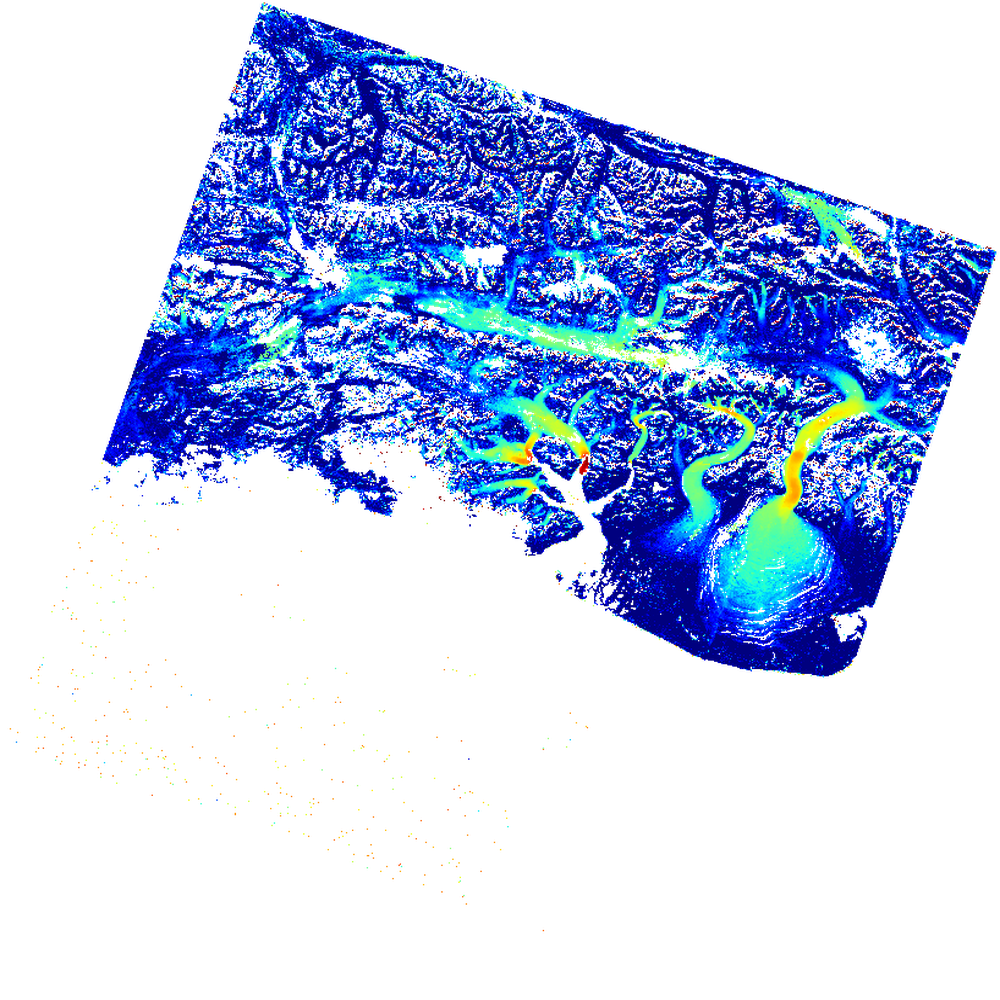

In [8]:
# This takes a minute when it is enabled
index = 2
print('year', year[index], 'day', doy[index])
ShowLocalImage('', fpng[index], 1000, 1000)

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np

In [ ]:
# Notice the filename structure:
# LANDSAT8 = L8_
# Path = 063_ is a choice of orbital imaging track
# Row = 018_ is a choice of cell along that track: path + row gives source image
# Delta time = 016_... the number of days separating the two source images
# Year_DOY of first image in pair 2014_050_
# Year_DOY of second image in pair 2014_066_
# Version of the motion tracking software 'v1.1'
print(f[0])

In [ ]:
# From cells above (in December 2018) we see a priori that there are 6 16-day-repeat pairs available
#   But it would be more appropriate to split on '_' and count how many [3] fields are '016'
n16s = 6
m = []
for i in range(n16s): m.append(xr.open_mfdataset(f[i]))

# We now have Xarray datasets m[0], m[1], ... , m[5] with a decent number of good values

### Deconstructing the data

Now that we have some datasets to consider let's start digging in further
- What are the dates under consideration? 
  - Well we can cheat by reading the filenames...
    - 2014_050_2014_066_v1.1.nc
    - 2014_066_2014_082_v1.1.nc
    - 2014_274_2014_290_v1.1.nc
    - 2015_341_2015_357_v1.1.nc
    - 2016_136_2016_152_v1.1.nc
    - ...but it would be better to be reading the dates as information from the files
- What data are available?
- We do know it is about velocities... so what are the velocities like? Typical range? Bad values? 

In [ ]:
# establish full scope of the dataset by simply naming it which amounts to a big 'print your guts' statement
m[0]

## Interpretation

From the above we see the data are in (y, x) coordinates so I'd guess UTM meters and the
derived observation of velocity will be in meters per day. I also think this will be in UTM zone 8, 
give or take.


In [ ]:
print(m[0]['vx_masked'])
print('\n')
print(m[0].vx_masked)          # should be identical to previous
print('\n')
print(m[0].vx_masked.x)
print('\n')
print(m[0].history)
# print(m[0].processing_log)

In [ ]:
#anticipating that the data are in UTM
!pip install utm
import utm

In [ ]:
# It is possible to use the 'directory' method dir(object) as in dir(m[0]['vv_masked'])
#   However this is not helpful because it dumps every darn inherited thing...
#   To see this just un-comment the following:
# dir(m[0]['vv_masked'])

In [ ]:
# There is a hint, though, buried in there; which is the qualifier 'values'. We will get into this shortly. 
# Next however let's try the 'print your guts' approach to a data variable from the above list.
m[0]['vx_masked']

In [ ]:
# Notice the above is not giving us a clue about how to see actual values of this 2D dask array
#   So we have a couple choices. Smart people (not me) will go read about 2D dask arrays and xarray DataArrays
#   and they will -- after careful study -- suddenly know exactly what they are doing. 
#   Stubborn impatient people like me will thrash around until they discover the .values 
#   qualifer whereupon they create a masterpiece of code like the following: 
m[0]['vv_masked'].values

In [ ]:
# Ok so we infer a few things from this print-your-guts:
#   - The array is capable of truncating itself to give us a sense of what is there without printing *everything*
#   - There are a lot of not-a-number values in the speed field (notice the focus is on 'vv' which is speed)
#   - This looks a lot like a list of lists... which is fine
#   - ...but we do not know how to index into some specific values
#
# Not to fear; some more thrashing and we have an indexing scheme. I used this with some trial-and-error to 
#   isolate down to three consecutive values as follows...
m[0]['vv_masked'][493,650:653].values

In [ ]:
# Now 18 meters per day glacier speed in southeast Alaska is pretty rare... so that is a warning flag that bad
#   values may live in the dataset disguised as good values. 
#
# In the above indexing scheme I notice that y may come first... or x. This is UTM so y is probably northing and
#   x is probably easting. But which comes first, y or x? From the printouts above I would guess y is the first 
#   index. Fortunately y has a bigger range so we can sanity check this: If the following line runs without an 
#   out-of-bounds issue then y comes first:
m[0]['vv_masked'][825,815].values

In [ ]:
# Ok not pretty but hypothesis verified. Switching the order produces an out-of-bounds.
# 
# Moving on to more about the coordinates and the values...
#    - The y's are in the 6.6 million range, the x's are in the 500,000 range.
#    - 18 meters per day is a bit high... 
#    - What we need is a plot to trial-and-error determine a good threshold for min and max speeds
minGuess = 0.01
maxGuess = 2.0
m[0].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=minGuess, vmax=maxGuess) # rainbow > bwr blue-white-red

# Uncomment these to focus on the interesting part of the image...
plt.xlim(400000,550000)
plt.ylim(6658000,6715000)

In [ ]:
# Returning to the question of 'when' for this data let's do the by-now obvious thing...
m[0]['image_pair_times']

In [ ]:
# ok let's just get the start_date attribute
m[0]['image_pair_times'].start_date

In [ ]:
# We actually have these dates 'in hand' when we can use them as Python datetimes
#   so let's do that conversion using 'string parse time' abbreviated 'strptime'
from datetime import datetime
d0 = datetime.strptime(m[0]['image_pair_times'].start_date, '%Y-%m-%dT%H:%M:%S')
d1 = datetime.strptime(m[0]['image_pair_times'].end_date, '%Y-%m-%dT%H:%M:%S')
print(d0)
print(d1)
print('interval is', d1 - d0)

### Another breath

Ok so good, now we have a handle on the time and we have a means of way of pulling out data values.
What we do not have yet is indexing by coordinates (i.e. by meters) instead of array index; and we 
do not have the end result, compilations of 'good data' sites where we can show speed variability with time.


Let's next hearken back to the idea of reading about xarray DataArrays to understand them. The documentation
proves to be a Tower of Hanoi as each sentence is full of terminology that leads to other pages of documentation.
More directed documentation can be found in the geohackweek GitHub repo:


[Geohackweek - nDarrays - xarray documentation](https://geohackweek.github.io/nDarrays/02-xarray-architecture/)


This site emphasizes that xarray DataArrays are extensions of the numpy nDarray n-dimensional array. 
'Extension' in the sense that they have labeled dimensions and coordinates. I don't fully appreciate the 
difference but key is getting away from indexing arrays by integers: 0, 1, ..., dim-1. 


Here is the official documentation link: 


[xarray DataArray documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)


The attributes of an xarray DataArray are five in number. They are referenced without brackets or quotes or parens...


- dims
- values
- coords
- name
- attrs is an ordered dictionary of metadata


Let's examine these five things in order for our good friend the masked speed array vv_masked:

In [ ]:
# Further proof that y comes first...
m[0]['vv_masked'].dims

In [ ]:
# This one was done up above; remember the list of lists of nans?
# m[0]['vv_masked'].values

In [ ]:
# x is listed first by y comes first in referencing locations; and notice x increases west to east
#   whereas y decreases north to south...
m[0]['vv_masked'].coords

In [ ]:
m[0]['vv_masked'].name

In [ ]:
m[0]['vv_masked'].attrs

In [ ]:
# Old-school programming with integer indices...
#   m[0]['vv_masked'][a:b,c:d].values uses integers a, b, c, d to print a matrix of speeds, as in...
a = 249        # the y values, indexing north to south decreasing numerical (see image above)
b = 251        #   and this corresponds to increasing index
c = 749        # the x values, indexing west to east increasing numerical
d = 751        #   and this corresponds to increasing index
m[0]['vv_masked'][a:b,c:d].values

...but this style of indexing by integers is what we are trying to escape...

In [ ]:
# y 493
# x 650
a=m[0]['vv_masked'][493,650]
print(a.coords)

In [ ]:
# y 493
# x 650
y0 = 250
a=m[0]['vv_masked'].isel(y=slice(493,499),x=slice(650,655))
print(a.coords['x'])
print(a.coords['y'])
print(a.values)

In [ ]:
northing = 6637657.5
easting = 528142.5
a = m[0]['vv_masked'].sel(y=northing, x=easting, method='nearest')
# a = m[0]['vv_masked'].sel(y=northing, x=easting)
a.values

### oh by the way... shortcuts

[This blog post](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/) has some really useful shortcuts
for operating Jupyter notebooks including the idea of an ESC escape mode:

- a adds a cell above
- b adds a cell below
- m changes a selected cell to markdown
- y changes a cell to code
- d twice deletes the current cell
- Shift + Tab will show you the Docstring (documentation) for the the object you have just typed in a code cell - you can keep pressing this short cut to cycle through a few modes of documentation
- Ctrl Shift - will split the current cell into two from where your cursor is
- f Find and replace on your code but not the outputs.
- o Toggle cell output


- Shift + J or Shift + down does multi-select downwards
- Shift + K or Shift + up does upwards
- Shift + M to merge


In [ ]:
a.values

In [ ]:
# At this point it is good to remember 
# I will compile a list of (x, y) tuples where the velocity is reasonable
#   so I am in effect masking the mask. 
min_good = 0.5
max_good = 10.0
good=[]

# This obvious nested loop approach is *very* slow but it does seem to work
# Notice it is commented out because there must be a faster way
# for j in range(300): # the 828 y-coordinate 
#     for i in range(300): # the 819 x-coordinate
#         s = m[0]['vv_masked'][j,i].values
#         if s >= min_good and s <= max_good:
#             good.append((j, i))

# This loop is instructive because it prints 819 twice meaning that it loops over the y-index 
#   and generates a list of the x values. I comment it out to move on to the next test.
# count = 0
# for speed in m[0]['vv_masked'][:]:    ...or equivalently...
# for speed in m[0]['vv_masked']:
#     print(len(speed.values))
#     count += 1
#     if count > 1: break

# count = 0
# for row in m[0]['vv_masked']:
#     for entry in row:
#         if entry.values >= min_good and entry.values <= max_good:
#             print(entry.values, entry.get_index('x'), entry['y'].values)
#             count += 1
#         if count > 0: break
#     if count > 0: break

# xr.where(m[0]['vv_masked'].values > min_good and m[0]['vv_masked'].values < max_good, good.append('fubar'))
# a = m[0]['vv_masked'].values.sel(values > min_good)

# >>> a = xr.DataArray(np.arange(25).reshape(5, 5), dims=('x', 'y'))
a = m[0]['vv_masked']
b = a.where((a > min_good) & (a < max_good))
print(b)
b.plot
# print(count)
# print(len(good))
# good

In [ ]:
minGuess = 0.0
maxGuess = 10.0
a.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=minGuess, vmax=maxGuess) # rainbow > bwr blue-white-red


In [ ]:
minGuess = 0.0
maxGuess = 10.0
b.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=minGuess, vmax=maxGuess) # rainbow > bwr blue-white-red


In [ ]:
good_copy=list(good)

In [ ]:
for i in range(50):
    print(m[0]['vv_masked'][good[i]].values)

In [ ]:
m[0].vv

In [ ]:
m[0].vv_masked

In [ ]:
hist_increment = 0.10
x0 = -2.5
x1 = 2.5
s0 = 0.0
s1 = 3.0
m[0].vx_masked.plot.hist(figsize=(7,7),bins=np.arange(x0,x1,hist_increment))
m[0].vy_masked.plot.hist(figsize=(7,7),bins=np.arange(x0,x1,hist_increment))
m[0].vv_masked.plot.hist(figsize=(7,7),bins=np.arange(s0,s1,hist_increment))

In [ ]:
m[0].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=-.2, vmax=10.) # over bwr blue-white-red
plt.xlim(400000,550000)
plt.ylim(6658000,6715000)


In [ ]:
print(m[0].vv_masked.speed_masked[0][0])

In [ ]:
print('hi')

In [ ]:
# from ShowCurrents(date_index)
X, Y = np.meshgrid(m[0]['y'], m[0]['x'])
U = m[0]['vy']
V = m[0]['vx']
plt.figure(figsize=(10,10))
plt.xlim(530000,545000)
plt.ylim(6682000,6688000)
# plt.title('ice velocities')
thisFigure = plt.quiver(X, Y, U, V, units='width')